In [1]:
from astropy.io import ascii
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.optimize import curve_fit

plt.rc('text', usetex = True) # Use LaTeX font in plots
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{gensymb}'
plt.rcParams.update({'font.size': 14})

In [13]:
def read_csv(filename):
    '''Read in .csv file and remove masked rows'''
    # Begin by reading in the .csv file
    cluster = ascii.read(filename, format='csv')
    # Remove rows that have masked G_BP or G_RP photometry values (all rows have G photometry values)
    cluster = cluster[(~cluster['phot_bp_mean_mag'].mask) & (~cluster['phot_rp_mean_mag'].mask)]
    return cluster

def convert_gaia_to_jc(G, G_BP, G_RP):
    '''Convert Gaia photometry to V and I passbands'''
    # Begin by converting G_BP - G_RP to V - I
    G_BP_minus_G_RP = G_BP - G_RP
    c, c1, c2 = -0.04212, 1.286, -0.09494
    c0 = c - G_BP_minus_G_RP
    V_minus_I = (-c1 + np.sqrt((c1**2) - (4*c2*c0)))/(2*c2)
    # Then convert V - I to G - V and solve for V
    d0, d1, d2, d3 = -0.01746, 0.008092, -0.2810, 0.03655
    G_minus_V = d0 + d1*V_minus_I + d2*(V_minus_I**2) + d3*(V_minus_I**3)
    V = -G_minus_V + G
    return V, V_minus_I

def plot_cmd(V_minus_I, V, cluster, fn, color, cmd_type):
    '''Plot a color magnitude diagram'''
    plt.figure(dpi = 200)
    plt.plot(V_minus_I, V, 'o'+color, ms = 0.5)
    plt.gca().invert_yaxis()
    plt.xlabel(r"V $-$ I")
    plt.ylabel("V")
    plt.title(cluster+" "+cmd_type+" Color Magnitude Diagram")
    plt.tight_layout()
    plt.savefig(fn+"_cmd.png", dpi = 300, facecolor='w', edgecolor='w')
    plt.show()
    
def plot_pmd(pmra, pmdec, cluster, fn, color, pmd_type, xlims = None, ylims = None):
    '''Plot a proper motion diagram'''
    plt.figure(dpi = 200)
    plt.plot(pmra, pmdec, 'o'+color, ms = 0.5)
    plt.xlabel(r"Right ascension proper motion ($\mu_{\mathrm{RA}} \cos(\delta),\ \mathrm{mas\ yr^{-1}}$)")
    plt.ylabel(r"Declination proper motion ($\mu_{\mathrm{dec}},\ \mathrm{mas\ yr^{-1}}$)")
    if xlims is not None and ylims is not None:
        plt.xlim(xlims[0], xlims[1])
        plt.ylim(ylims[0], ylims[1])
    plt.title(cluster+" "+pmd_type+" Proper Motion Diagram")
    plt.tight_layout()
    plt.savefig(fn+"_pmd.png", dpi = 300, facecolor='w', edgecolor='w')
    plt.show()
    
def gaussian(x, a, mu, sigma):
    return a*np.exp(-.5*(x-mu)**2/(sigma**2))

def double_gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
    return a1*np.exp(-.5*(x-mu1)**2/(sigma1**2)) + a2*np.exp(-.5*(x-mu2)**2/(sigma2**2))

def fit_functions(arr, fit_type, cluster, color, data_type, guesses = None):
    'Fit one or two Gaussian functions to binned data and return fit parameters.'
    binsize = 0.5
    # Bin data and fit Gaussian function(s) to the bins
    counts, bins = np.histogram(arr.ravel(), bins=np.arange(np.min(arr), np.max(arr), binsize))
    if fit_type == 'single':
        popt, pcov = curve_fit(gaussian, xdata=bins[:-1], ydata=counts, p0=guesses) # len 3
        fit = gaussian(bins[:-1], *popt)
    elif fit_type == 'double':
        popt, pcov = curve_fit(double_gaussian, xdata=bins[:-1], ydata=counts, p0=guesses) # len 6
        fit = double_gaussian(bins[:-1], *popt)
    # Plot histogram and fit
    plt.figure(dpi = 200)
    plt.step(bins[:-1]+(binsize/2.0), counts, color="xkcd:black", label="binned data")
    plt.plot(bins[:-1], fit, color, label="Gaussian fit(s)")
    if data_type == 'RA':
        plt.xlabel(r"Right ascension proper motion ($\mu_{\mathrm{RA}} \cos(\delta),\ \mathrm{mas\ yr^{-1}}$)")
        plt.title(cluster+r" $\mu_{\mathrm{RA}} \cos(\delta)$ Proper Motion Histogram")
    elif data_type == 'dec':
        plt.xlabel(r"Declination proper motion ($\mu_{\mathrm{dec}},\ \mathrm{mas\ yr^{-1}}$)")
        plt.title(cluster+r" $\mu_{\mathrm{dec}}$ Proper Motion Histogram")
#     plt.xlim(-100, 100)
    plt.ylabel("Counts per bin")
    plt.legend(loc="best")
#     plt.savefig(cluster+"_"+data_type+"_hist.png", dpi = 300, facecolor='w', edgecolor='w')
    plt.show()
    return popt

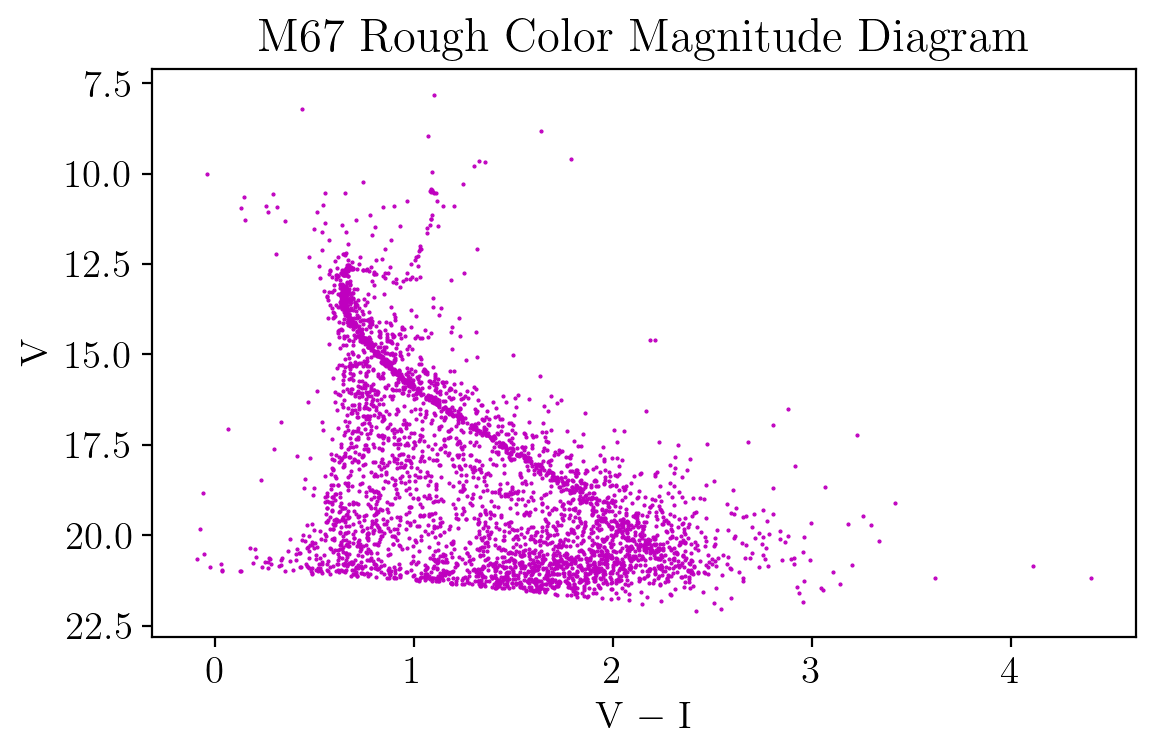

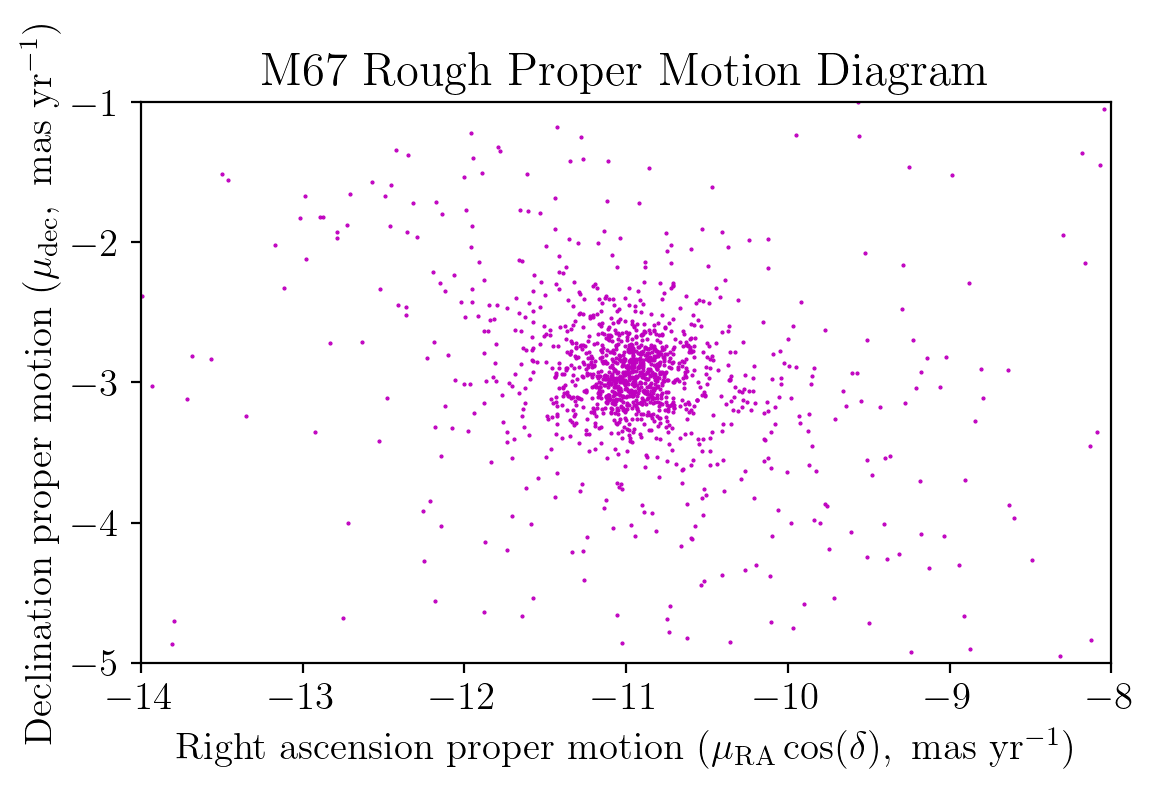

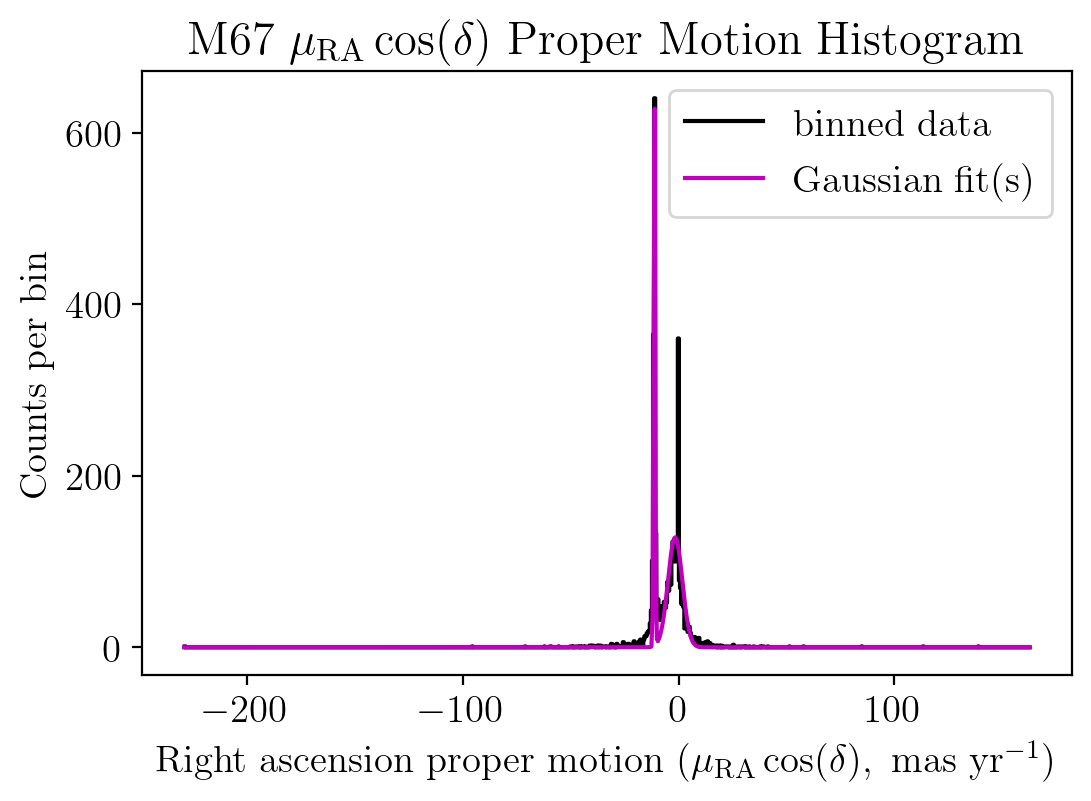

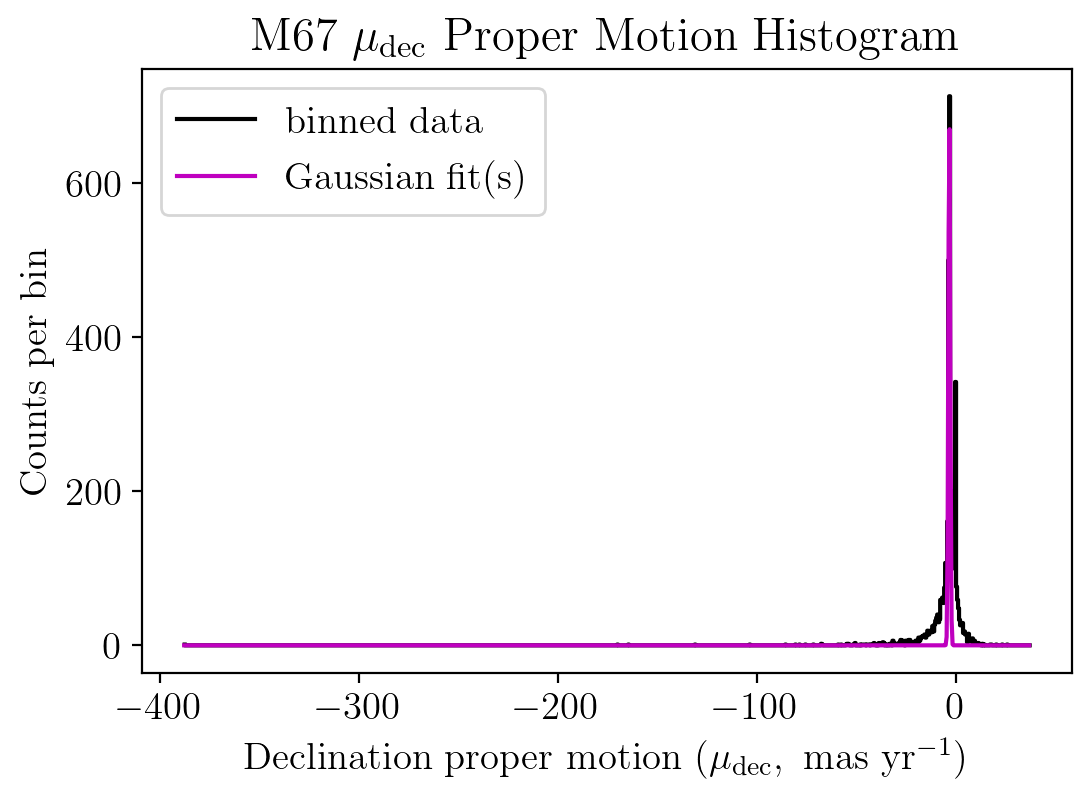

RA center:  -11.185168555221107
RA 3sigma width:  1.0823891171330855
Dec center:  -3.1800463649598454
Dec 3sigma width:  1.3988005597581004


In [16]:
color = 'm'
M67 = read_csv('M67-result.csv')
M67['V'], M67['V_minus_I'] = convert_gaia_to_jc(M67['phot_g_mean_mag'], 
                                                M67['phot_bp_mean_mag'], 
                                                M67['phot_rp_mean_mag'])

plot_cmd(M67['V_minus_I'], M67['V'], 'M67', 'M67_rough', color, 'Rough')

plot_pmd(M67['pmra'], M67['pmdec'], 'M67', 'M67_rough', color, 'Rough',
         xlims = (-14, -8), ylims = (-5, -1))

RA_a, RA_mu, RA_sigma, \
RA_a2, RA_mu2, RA_sigma2 = fit_functions(M67['pmra'], 'double', 'M67', color, 'RA', 
                                         guesses = [600,-15,2,1200,-2,2])
dec_a, dec_mu, dec_sigma = fit_functions(M67['pmdec'], 'single', 'M67', color, 'dec', 
                                         guesses = [400,0,0.1])
print("RA center: ",RA_mu)
print("RA 3sigma width: ", 3*np.abs(RA_sigma))
print("Dec center: ",dec_mu)
print("Dec 3sigma width: ", 3*np.abs(dec_sigma))

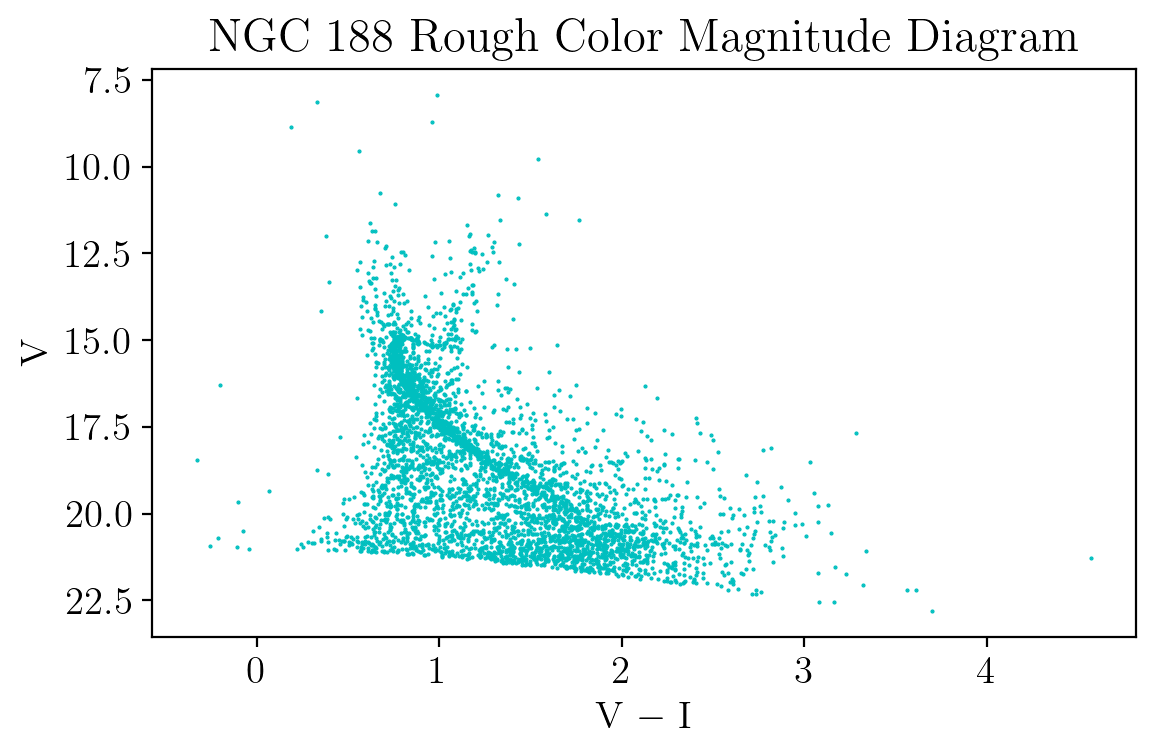

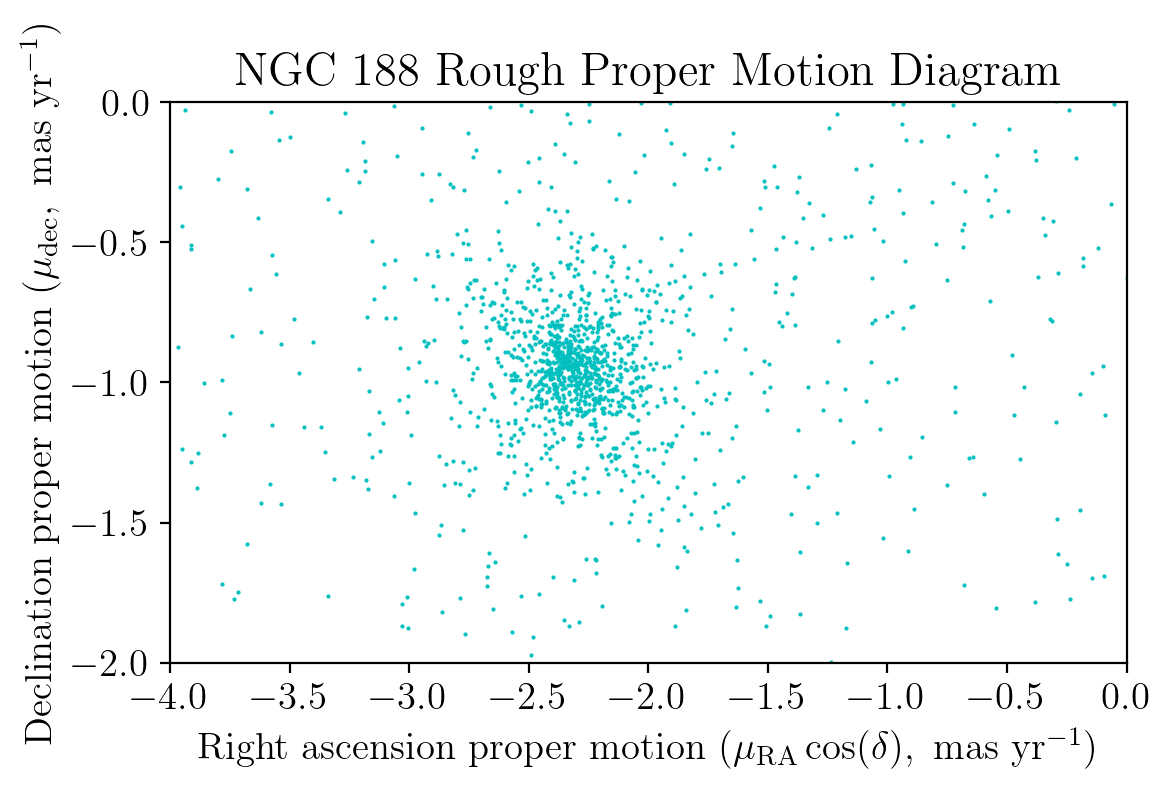

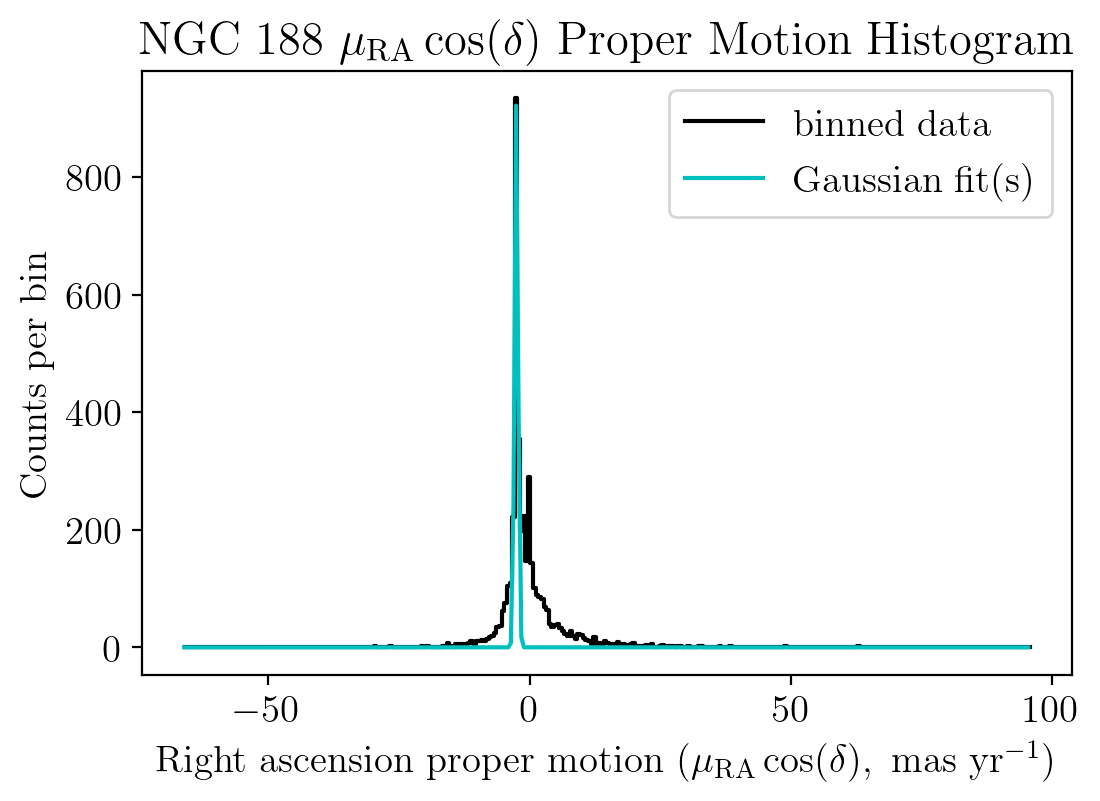

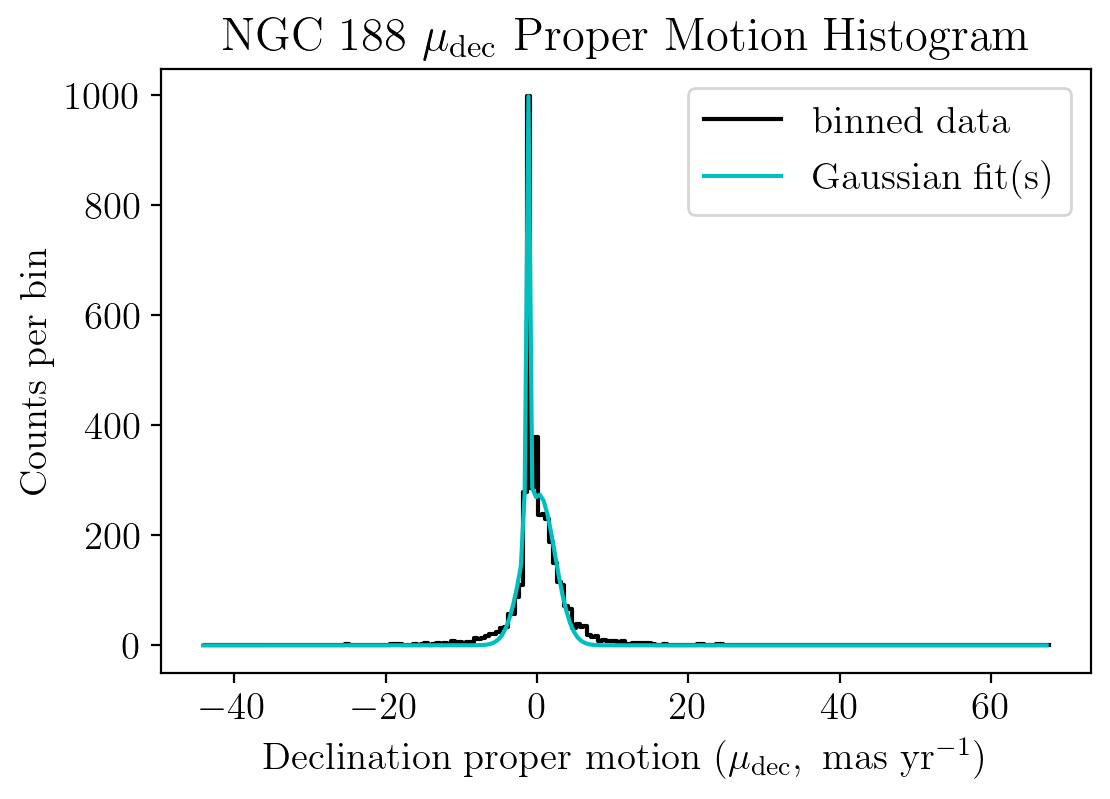

RA center:  -2.567698600671472
RA 3sigma width:  1.008381285777191
Dec center:  -1.1927041368784856
Dec 3sigma width:  0.6578534225504472


In [17]:
color = 'c'
NGC188 = read_csv('NGC188-result.csv')
NGC188['V'], NGC188['V_minus_I'] = convert_gaia_to_jc(NGC188['phot_g_mean_mag'],
                                                      NGC188['phot_bp_mean_mag'], 
                                                      NGC188['phot_rp_mean_mag'])

plot_cmd(NGC188['V_minus_I'], NGC188['V'], 'NGC 188', 'NGC188_rough', color, 'Rough')

plot_pmd(NGC188['pmra'], NGC188['pmdec'], 'NGC 188', 'NGC188_rough', color, 'Rough', 
         xlims = (-4, 0), ylims = (-2, 0))

RA_a, RA_mu, RA_sigma = fit_functions(NGC188['pmra'], 'single', 'NGC 188', color, 'RA', 
                                      guesses = [900,-15,2])
dec_a, dec_mu, dec_sigma, \
dec_a2, dec_mu2, dec_sigma2 = fit_functions(NGC188['pmdec'], 'double', 'NGC 188', color, 'dec', 
                                            guesses = [900,-2,2,300,0,2])

print("RA center: ",RA_mu)
print("RA 3sigma width: ", 3*np.abs(RA_sigma))
print("Dec center: ",dec_mu)
print("Dec 3sigma width: ", 3*np.abs(dec_sigma))

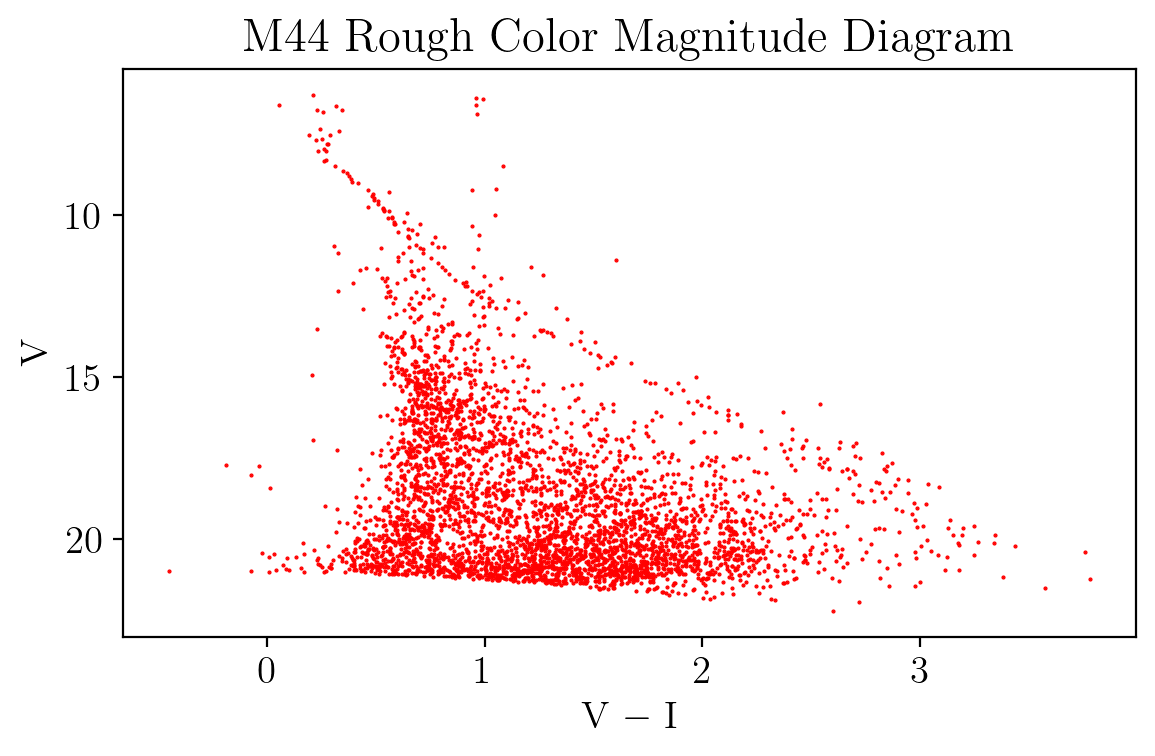

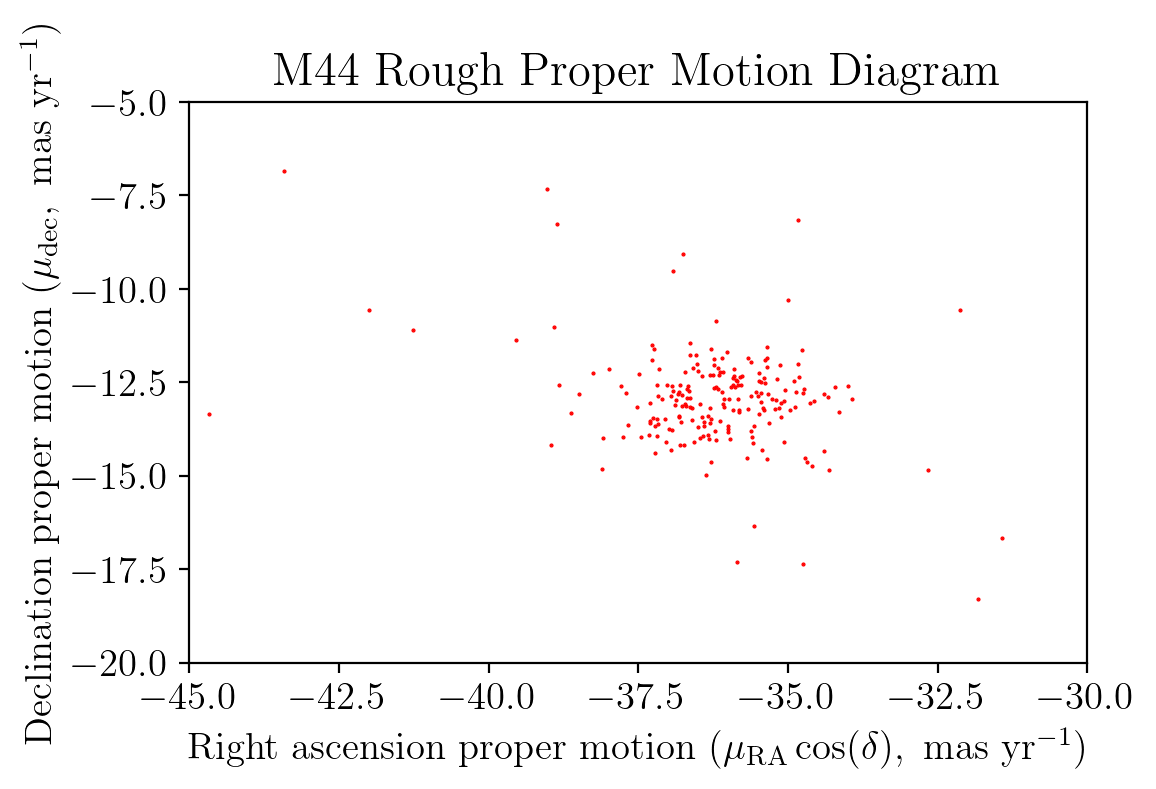

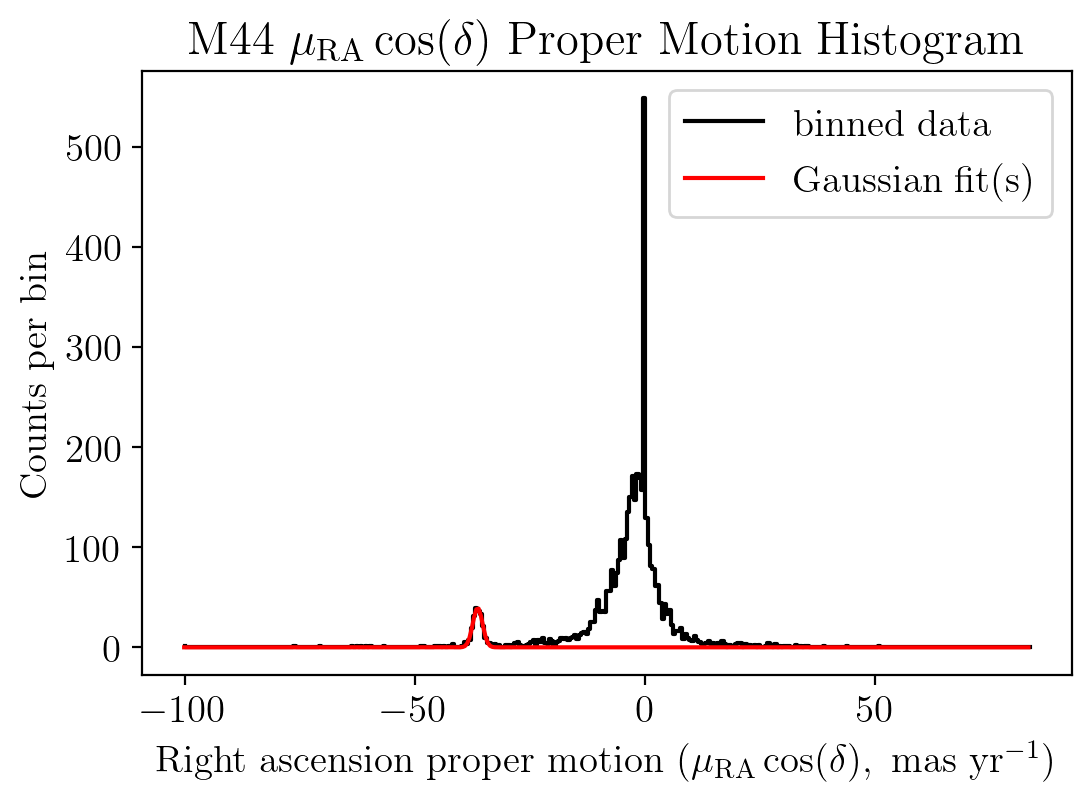

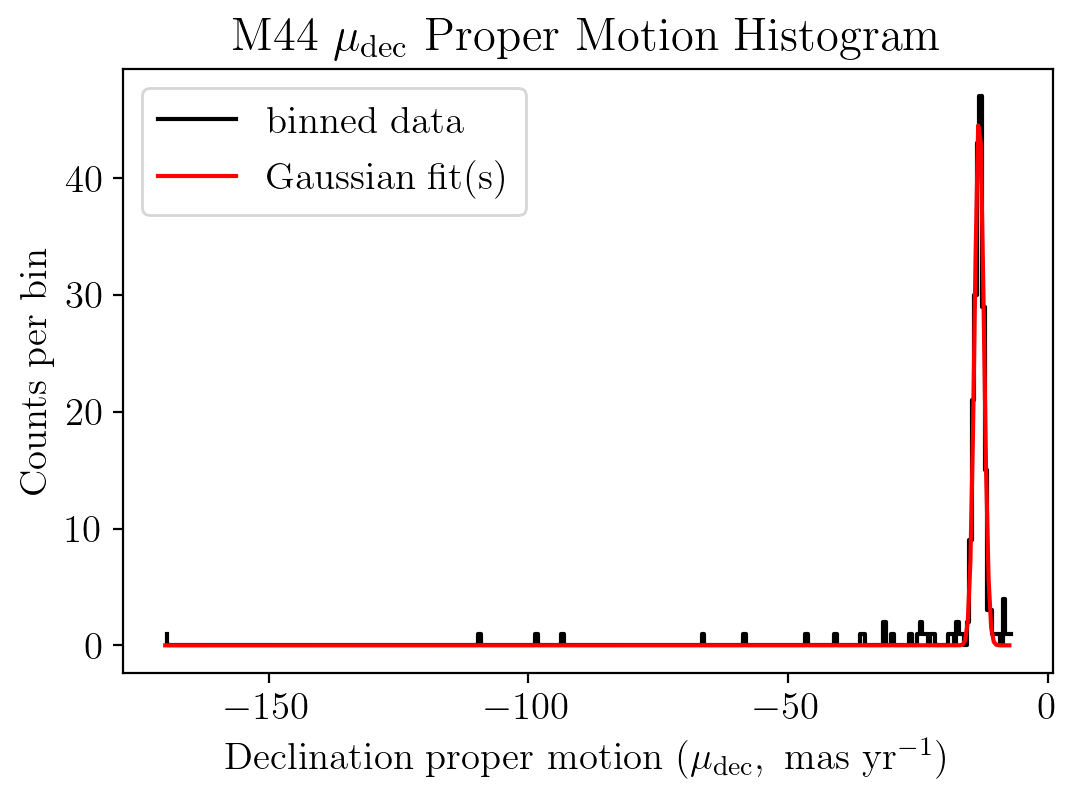

RA center:  -36.374502017678196
RA 3sigma width:  3.1674068032087854
Dec center:  -13.227938742496864
Dec 3sigma width:  2.6476753275202034


In [18]:
color = 'r'
M44 = read_csv('M44-result.csv')
M44['V'], M44['V_minus_I'] = convert_gaia_to_jc(M44['phot_g_mean_mag'], 
                                                M44['phot_bp_mean_mag'], 
                                                M44['phot_rp_mean_mag'])

plot_cmd(M44['V_minus_I'], M44['V'], 'M44', 'M44_rough', color, 'Rough')

plot_pmd(M44['pmra'], M44['pmdec'], 'M44', 'M44_rough', color, 'Rough', 
         xlims = (-45, -30), ylims = (-20, -5))

# Place restrictions on stars used for declination fit, using arbitrary user-decided cutoffs
M44_int = M44[M44['pmdec']<-6.]
M44_lim = M44_int[M44_int['pmra']<-25.]

RA_a, RA_mu, RA_sigma = fit_functions(M44['pmra'], 'single', 'M44', color, 'RA',
                                      guesses = [100,-36,2])
dec_a, dec_mu, dec_sigma = fit_functions(M44_lim['pmdec'],'single', 'M44', color, 'dec',
                                         guesses = [150,-20,1])

print("RA center: ",RA_mu)
print("RA 3sigma width: ", 3*np.abs(RA_sigma))
print("Dec center: ",dec_mu)
print("Dec 3sigma width: ", 3*np.abs(dec_sigma))

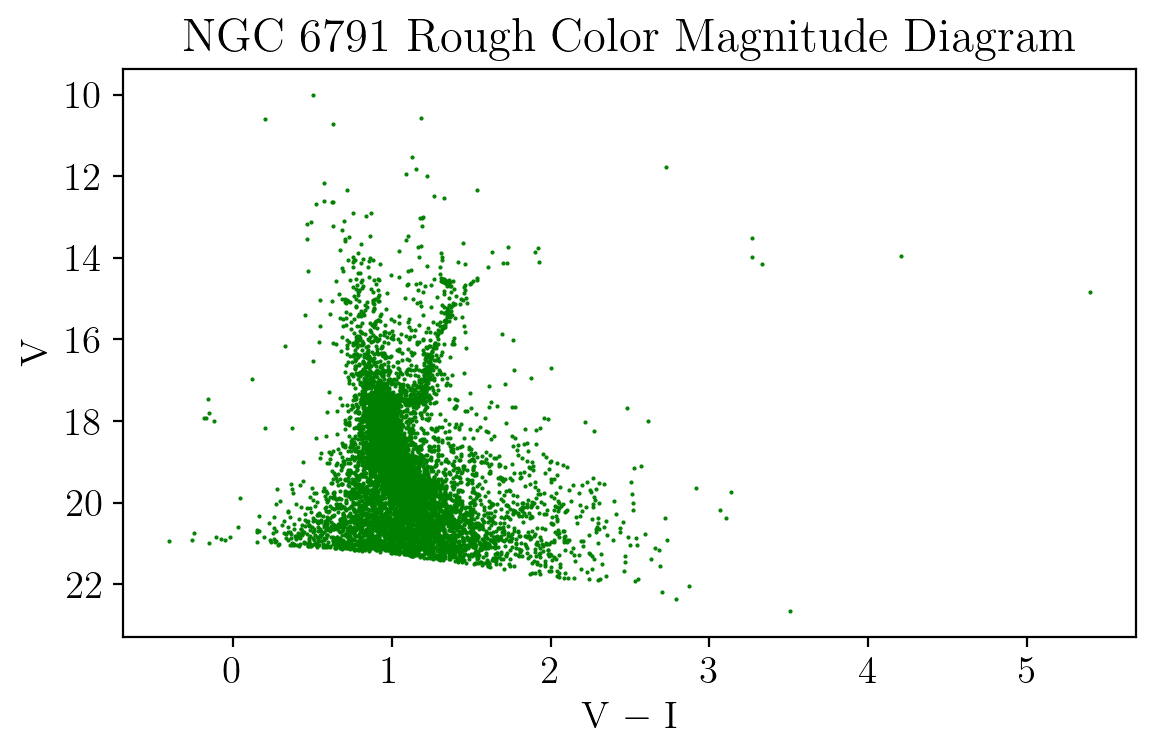

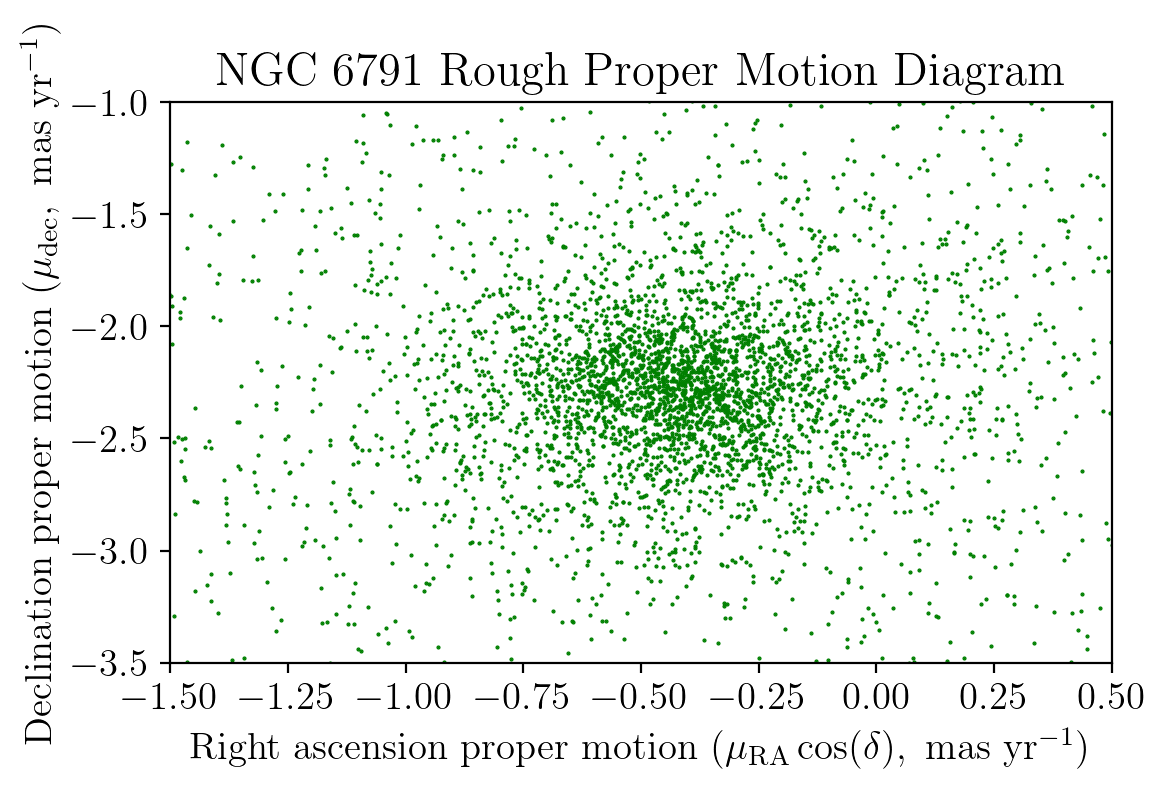

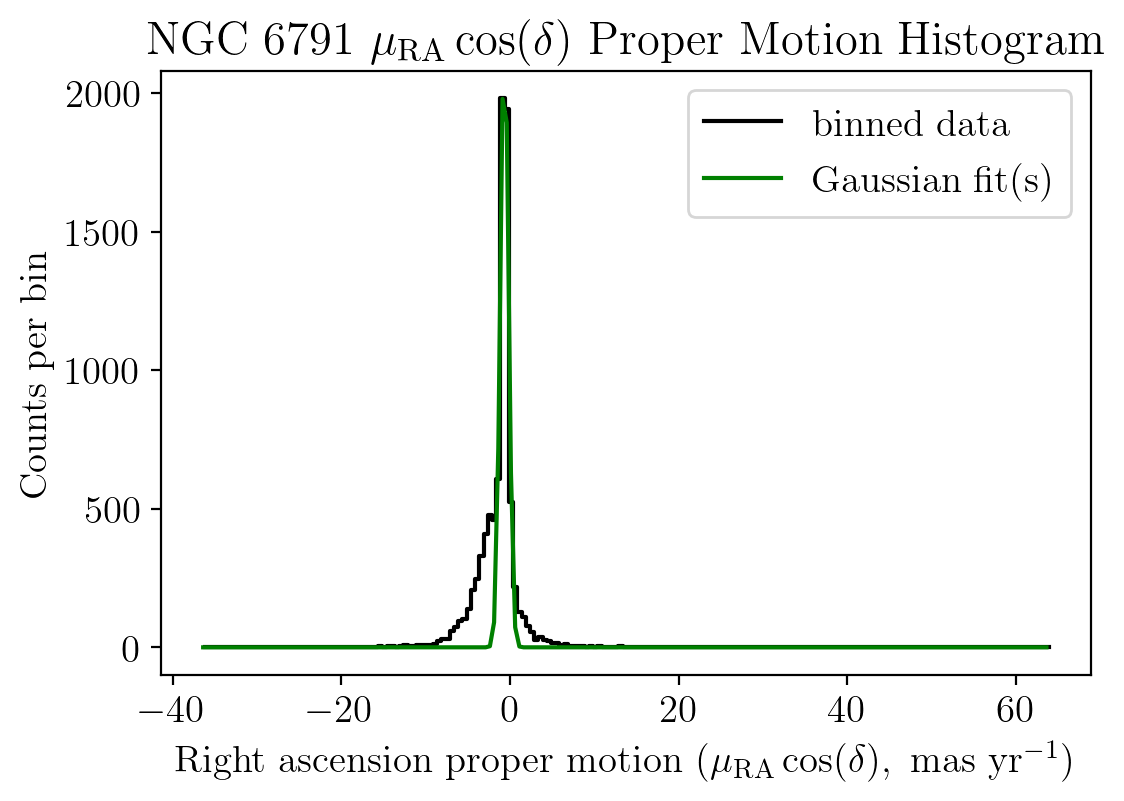

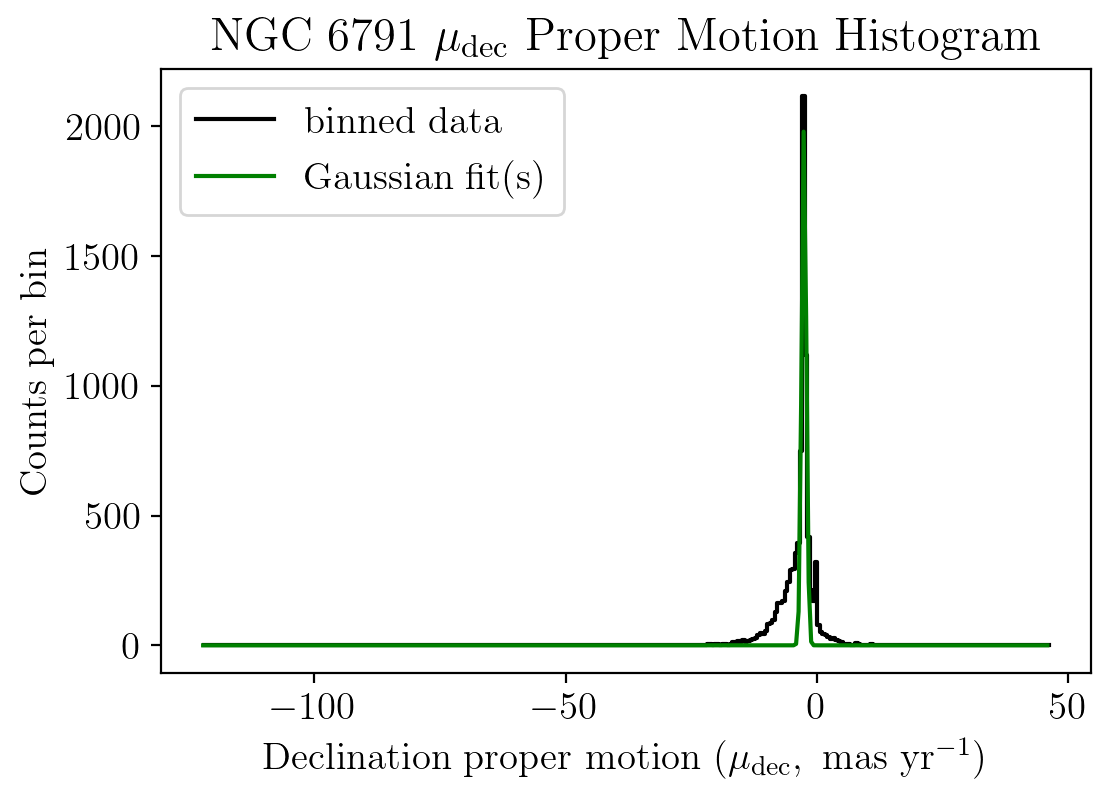

RA center:  -0.6638341786498551
RA 3sigma width:  1.4581791026344189
Dec center:  -2.5571619095265694
Dec 3sigma width:  1.3665942628497871


In [19]:
color = 'g'
NGC6791 = read_csv('NGC6791-result.csv')
NGC6791['V'], NGC6791['V_minus_I'] = convert_gaia_to_jc(NGC6791['phot_g_mean_mag'],
                                                        NGC6791['phot_bp_mean_mag'], 
                                                        NGC6791['phot_rp_mean_mag'])

plot_cmd(NGC6791['V_minus_I'], NGC6791['V'], 'NGC 6791', 'NGC6791_rough', color, 'Rough')

plot_pmd(NGC6791['pmra'], NGC6791['pmdec'], 'NGC 6791', 'NGC6791_rough', color, 'Rough',
         xlims = (-1.5, 0.5), ylims = (-3.5, -1))

RA_a, RA_mu, RA_sigma = fit_functions(NGC6791['pmra'], 'single', 'NGC 6791', color, 'RA', 
                                      guesses = [1400,-15,2])
dec_a, dec_mu, dec_sigma = fit_functions(NGC6791['pmdec'], 'single', 'NGC 6791', color, 'dec', 
                                         guesses = [3000,-5,2])

print("RA center: ",RA_mu)
print("RA 3sigma width: ", 3*np.abs(RA_sigma))
print("Dec center: ",dec_mu)
print("Dec 3sigma width: ", 3*np.abs(dec_sigma))

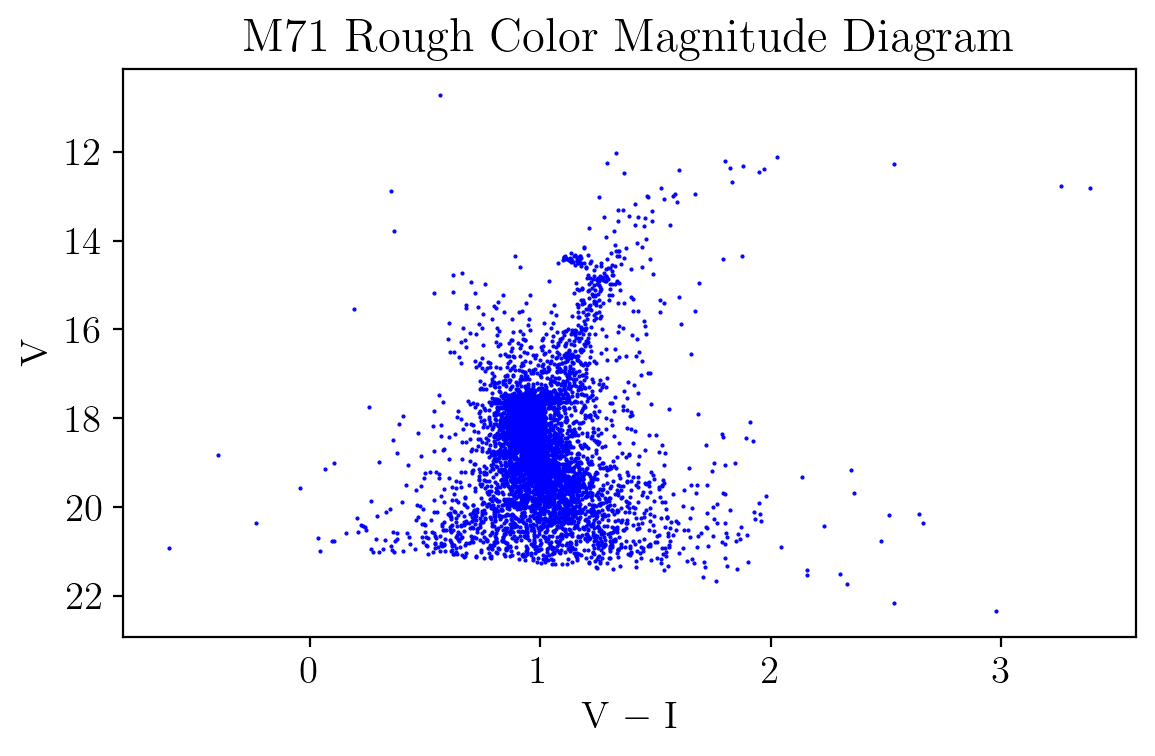

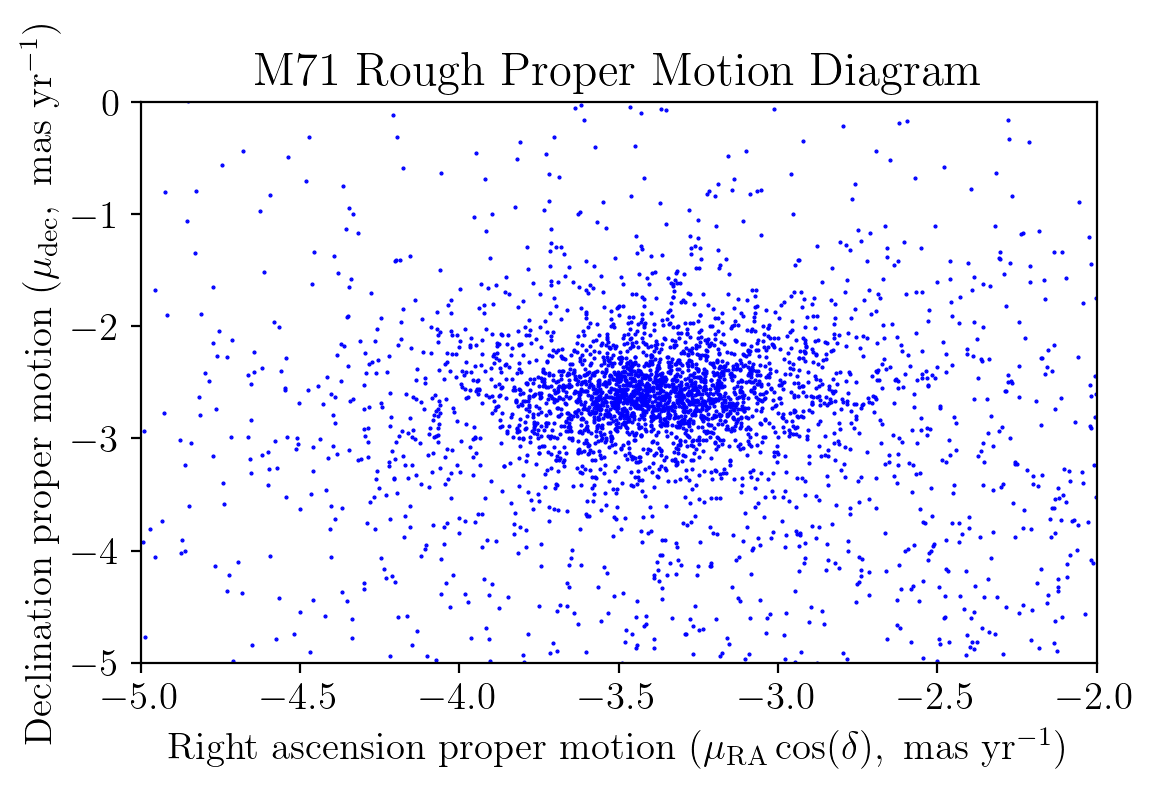

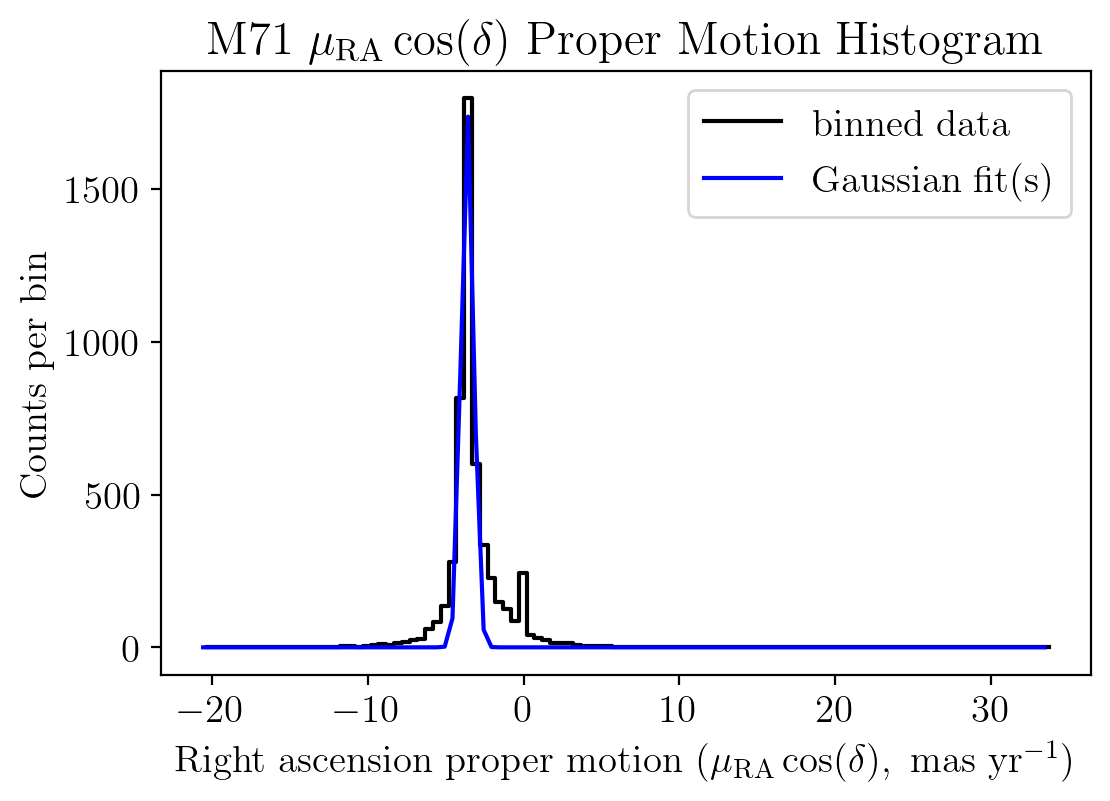

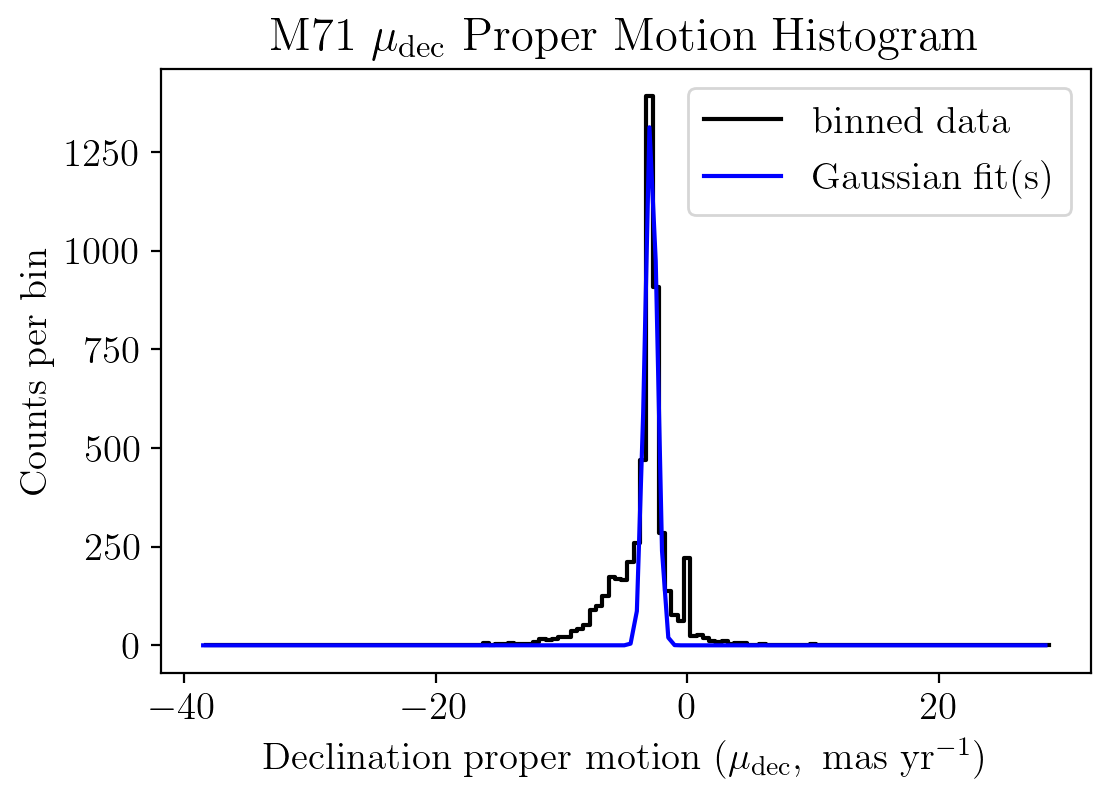

RA center:  -3.605803542042813
RA 3sigma width:  1.1936660396782743
Dec center:  -2.897881450454481
Dec 3sigma width:  1.4272879446933118


In [20]:
color = 'b'
M71 = read_csv('M71-result.csv')
M71['V'], M71['V_minus_I'] = convert_gaia_to_jc(M71['phot_g_mean_mag'], 
                                                M71['phot_bp_mean_mag'], 
                                                M71['phot_rp_mean_mag'])

plot_cmd(M71['V_minus_I'], M71['V'], 'M71', 'M71_rough', color, 'Rough')

plot_pmd(M71['pmra'], M71['pmdec'], 'M71', 'M71_rough', color, 'Rough',
         xlims = (-5, -2), ylims = (-5, -0))

RA_a, RA_mu, RA_sigma = fit_functions(M71['pmra'], 'single', 'M71', color, 'RA', 
                                      guesses = [1600,-5,2])
dec_a, dec_mu, dec_sigma = fit_functions(M71['pmdec'], 'single', 'M71', color, 'dec', 
                                         guesses = [1400,-5,2])

print("RA center: ",RA_mu)
print("RA 3sigma width: ", 3*np.abs(RA_sigma))
print("Dec center: ",dec_mu)
print("Dec 3sigma width: ", 3*np.abs(dec_sigma))